In this homework we attempt to build a classifier which can sort images into 1 of 50 catigories with a high fidelity using a Random Forrest method.

First we load all images

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import skimage
import os
import random
from skimage import data, io, filters

path = '50_categories/'  #folder containing subfolders of images of a certain class

folders = [f for f in sorted(os.listdir(path))] #get all subfolders
images = {}
index_map = []

#loop over folders in path and load images into a dictionary keyed on the catigory
for i,f in enumerate(folders[2:12]):  #loop over folders
    folder_path = path + f +'/'
    key = "cat_" + str(i)  #catigory name
    image_catigory = []
    index_map.append(f)  #map to decode what each catigory is
    for file in sorted(os.listdir(folder_path)):
        file_path = folder_path + file
        img=mpimg.imread(file_path)  #load image
        image_catigory.append((img,i))  #append to list of images along with an integer that encodes the appropriate classification
    images[key] = image_catigory #put list of images in dictionary
    print("Done with",f)


Done with bat
Done with bear
Done with blimp
Done with camel
Done with comet
Done with conch
Done with cormorant
Done with crab
Done with dog
Done with dolphin


Lets look through some of the images

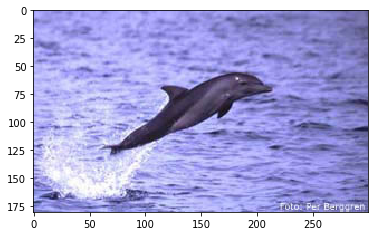

In [5]:
plt.imshow(images['cat_'+str(random.randint(0,49))][random.randint(0,50)][0])  #grab a random image from the set
plt.show()

Now we split the data into a test set and training set

In [7]:
train_percentage = .9  #set the percent of data put in the training set
train_set = []
test_set = []

#loop over each type of image so each catigory gets the same percentage representation in the data
for key in images:
    imlist = images[key]
    random.shuffle(imlist)  #shuffle the images so we don't get the same ones every time
    cutoff = int(.9*len(imlist))
    train_set.extend(imlist[:cutoff])  #load training data
    test_set.extend(imlist[cutoff:]) #load test data
    
random.shuffle(train_set)  #shuffle both data sets again so we don't train on one type of image before others
random.shuffle(test_set)


Now we need to create some function to extract features from these images to train our random forest on.

In [8]:
import cv2

def avg_colors(r,g,b): #extract the average value of the red, green and blue channels in an image 
    return np.mean(r),np.mean(g),np.mean(b)

def std_colors(r,g,b): #extract the spread in the 3 color channels individually
    return np.std(r),np.std(g),np.std(b)

def color_difs(r,g,b): #extract the average difference between each color channel
    return np.mean(r-g),np.mean(r-b),np.mean(g-b)

# def dot_product(r,g,b):
#     return np.mean(np.dot(r,g.T)),np.mean(np.dot(r,b.T)),np.mean(np.dot(b,g.T))

def find_edges(r,g,b):  #find the edges of an image. To convert this to a number, we aveage this image which gives us something like the length of boundaries in the picture
    return np.mean(filters.sobel(r)),np.mean(filters.sobel(g)),np.mean(filters.sobel(b))

def find_max(r,g,b): #extract the intensity that is most common in each color channel
    maximum = []
    for im in [r,g,b]:
        hist = cv2.calcHist(im,[0],None,[256],[50,200])
        hist = list(hist)
        maximum.append(hist.index(max(hist)))
    return maximum
    

Lets look at some of the features and what they look like

This is what the boarder finder produces


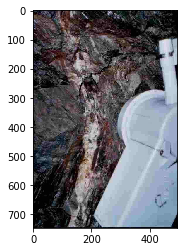

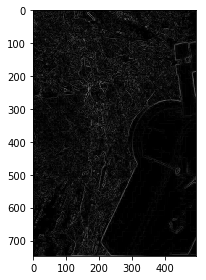

In [15]:
print('This is what the boarder finder produces')

plt.imshow(train_set[123][0])
plt.show()

image = train_set[123][0]
edges = filters.sobel(image[:,:,1])
io.imshow(edges)
io.show()


This is an example of what the histogram of a color chanel look like. We find the average and the mode of this histogram. 


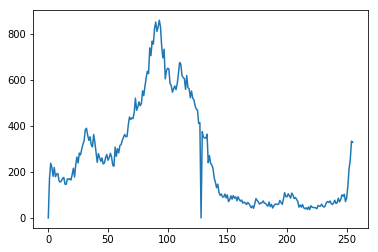

In [20]:
print('This is an example of what the histogram of a color chanel look like. We find the average and the mode of this histogram. ')

plt.plot(cv2.calcHist([img[:,:,1]],[0],None,[256],[1,255]))
plt.show()



I looked into building a feature based on historgrams of oriented images but I couldn't quite get it to work or how to properly get it to be a single number that could be used as a feature.

In [23]:

from skimage.feature import hog  

x = hog(image[:,:,1], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1))

print(len(x))
plt.show(hog_image)

11040


/Users/Erik/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Function to compile the feature extraction functions

In [10]:
def extract_features(im):
    features = []
    if len(im.shape) != 3:  #split the image into RGB channels unless it is black and white
        r = g = b = im
    else:
        r = im[:,:,0]
        g = im[:,:,1]
        b = im[:,:,2]
    features.extend(std_colors(r,g,b))
    features.extend(avg_colors(r,g,b))
    features.extend(color_difs(r,g,b))
    features.extend(find_edges(r,g,b))
    #features.extend(dot_product(r,g,b)) #Can take a really long time for some reason
    features.extend(find_max(r,g,b))
    return features
    

Now lets actually extract the features 

In [11]:
import time
from sklearn import preprocessing

Xtrain = []
Ytrain = []
for i,img in enumerate(train_set):  #loop over images in train set and extract their features
    t0 = time.time() #time feature extraction incase one is taking particularly long
    Xtrain.append(extract_features(img[0]))  #load list of features into Xtrain
    Ytrain.append(img[1]) #load corresponding answers into another list
    tf = time.time()
    if tf-t0 > 1:  #alert user if an image is taking more than 1s to featurize
        print("Index",i,"took",tf-t0,"s")
    if np.mod(i,50) ==0:  #keep track of how fast the featurization is going
        print(i,"out of",len(train_set)-1,"complete")
print(i,"out of",len(train_set)-1,"complete")
        
#repeat for test data    
Xtest = []
Ytest = []
for i,img in enumerate(test_set):
    Xtest.append(extract_features(img[0]))
    Ytest.append(img[1]) #the answer
    if np.mod(i,50) ==0:
        print(i,"out of",len(test_set)-1,"complete")
print(i,"out of",len(test_set)-1,"complete")

Xtrain = preprocessing.scale(Xtrain) #scale the features to have a unity norm and spread
Xtest = preprocessing.scale(Xtest) 

0 out of 611 complete
50 out of 611 complete
100 out of 611 complete
150 out of 611 complete
200 out of 611 complete
250 out of 611 complete
300 out of 611 complete
350 out of 611 complete
400 out of 611 complete
Index 450 took 1.540431261062622 s
450 out of 611 complete
500 out of 611 complete
550 out of 611 complete
600 out of 611 complete
611 out of 611 complete
0 out of 73 complete
50 out of 73 complete
73 out of 73 complete


Now let us create our classifier

In [48]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=25)

#train the classifier
classifier.fit(Xtrain, Ytrain)

#see how it does on the test data
predictions = classifier.predict(Xtest) 


[[-0.71073695 -1.00927365 -0.77594287 ..., -0.44063973 -0.61549617
  -0.6541775 ]
 [-1.30301627 -1.30127955 -1.19747423 ...,  0.6892611   0.44895579
   0.07251852]
 [ 1.55470807  1.86303155  1.78294186 ..., -0.88575218 -1.01762247
  -0.98957566]
 ..., 
 [ 0.18401408  0.7591396   1.6241895  ..., -0.88575218 -1.01762247
  -0.98957566]
 [-1.78638168 -1.79392981 -1.61361716 ..., -0.88575218 -1.01762247
  -0.06164074]
 [-0.95614932  0.26587533  1.92676486 ..., -0.32650833  1.07579973
  -0.30759939]]


Now that we've created and trained the classifier, lets see how it does

Zero-One Score: 0.324324324324
Confusion Matrix:
[i, j] is the # of objects truly in group i but predicted to be in group j


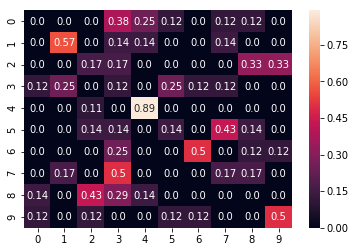

In [35]:
from sklearn import metrics

prec_correct = metrics.accuracy_score(Ytest, predictions) # zero-one score
cm = metrics.confusion_matrix(Ytest, predictions) # confusion matrix
rf_confmat = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print("Zero-One Score: " + str(prec_correct))
print("Confusion Matrix:")
print("[i, j] is the # of objects truly in group i but predicted to be in group j")

import seaborn as sns

sns.heatmap(np.around(rf_confmat[:10,:10],2), annot=True,  fmt='', 
            xticklabels=[str(x) for x in range(10)], yticklabels=[str(x) for x in range(10)]);

In [31]:
rf_precision = metrics.precision_score(Ytest, predictions,average="weighted") # TP / (TP + FP)
rf_recall = metrics.recall_score(Ytest, predictions,average="weighted") # TP / (TP + FN)

print("Avg. Precision: ",rf_precision)
print("Avg. Recall: ", rf_recall)

Avg. Precision:  0.328904953905
Avg. Recall:  0.324324324324


/Users/Erik/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


These are the list of how important each feature is

In [36]:
print(classifier.feature_importances_)

[ 0.07289312  0.0704222   0.06209805  0.08724593  0.07709432  0.08659383
  0.08525526  0.07441323  0.06966782  0.05632343  0.05879235  0.05828161
  0.04314273  0.04596177  0.05181436]


All features are roughly equally important in this scheme.

In [72]:
def test_new_set(file_path,classifier):
    answers =[]
    outF = open("classifier_results.txt", "w")
    outF.write("File \t Predicted Answer \n")
    outF.write("--------------------------- \n")
    
    for file in sorted(os.listdir(file_path)):
            path = file_path + file
            img=mpimg.imread(path)  #load image
            features = extract_features(img[0])
            prediction = classifier.predict([features])     #catigorize image
            outF.write(file)
            outF.write("\t")
            catigory = index_map[prediction[0]]
            outF.write(catigory)
            outF.write("\n")
    outF.close()


In [73]:
test_new_set("50_categories/bear/",classifier)

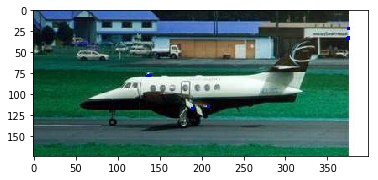

In [16]:
import cv2
import numpy as np

filename = '50_categories/airplanes/airplanes_0017.jpg'
img = cv2.imread(filename)
# gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

# gray = np.float32(gray)
dst = cv2.cornerHarris(img[:,:,0],4,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.5*dst.max()]=[0,0,255]

plt.imshow(img)


/Users/Erik/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


ValueError: cannot reshape array of size 8232 into shape (174,399)